In [1]:
import os
from pathlib import Path

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd().parent.resolve()

os.chdir(PROJECT_ROOT)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from paths import DATA_DIR
from pyrepseq.metric import tcr_metric
from sceptr import variant
from scipy import stats

plt.style.use("ggplot")
#plt.style.use("my.mplstyle")

In [3]:
def get_nn_pairs(anchors: DataFrame, comparisons: DataFrame, model) -> list[tuple[int, int]]:
    anchor_indices = anchors.index.to_list()
    cdist_matrix = model.calc_cdist_matrix(anchors, comparisons)
    cdist_matrix[range(len(anchors)),anchor_indices] = 1000

    nn_indices = np.argmin(cdist_matrix, axis=1)
    return [tuple(sorted((a_idx, c_idx))) for a_idx, c_idx in zip(anchor_indices, nn_indices)]

In [4]:
# Load all TCRs from Tanno test set
tanno_test = pd.read_csv(DATA_DIR/"preprocessed"/"tanno"/"test.csv")

# Get 500 random near-distance TCR pairs according to SCEPTR
sceptr_model = variant.default()
sceptr_500_tcrs = tanno_test.sample(n=500, random_state=420)
sceptr_500_pairs = get_nn_pairs(sceptr_500_tcrs, tanno_test, sceptr_model)

/home/andreas/mambaforge/envs/sceptr_publication_analyses/lib/python3.12/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


In [5]:
# Get 500 random near-distance TCR pairs according to TCRdist
tcrdist_model = tcr_metric.Tcrdist()
tcrdist_500_tcrs = tanno_test.sample(n=500, random_state=421)
tcrdist_500_pairs = get_nn_pairs(tcrdist_500_tcrs, tanno_test, tcrdist_model)

In [6]:
tcrdist_model_alpha = tcr_metric.AlphaTcrdist()
tcrdist_model_beta = tcr_metric.BetaTcrdist()

In [7]:
combined_pairs = list(set(sceptr_500_pairs + 
                        tcrdist_500_pairs
                        ))

sceptr_dists = []
tcrdist_dists = []
tcrdist_alpha_dists = []
tcrdist_beta_dists = []

for pair in combined_pairs:
    tcr_pair = tanno_test.loc[list(pair)]
    sceptr_dists.append(sceptr_model.calc_pdist_vector(tcr_pair).item())
    tcrdist_dists.append(tcrdist_model.calc_pdist_vector(tcr_pair).item())
    tcrdist_alpha_dists.append(tcrdist_model_alpha.calc_pdist_vector(tcr_pair).item())
    tcrdist_beta_dists.append(tcrdist_model_beta.calc_pdist_vector(tcr_pair).item())

tcrdist_alpha_dists = np.array(tcrdist_alpha_dists)
tcrdist_beta_dists = np.array(tcrdist_beta_dists)
tcrdist_dists = np.array(tcrdist_dists)

In [8]:
tcr_dist_df = DataFrame(combined_pairs, columns=["anchor_idx", "comparison_idx"])
tcr_dist_df["SCEPTR"] = sceptr_dists
tcr_dist_df["TCRdist"] = tcrdist_dists
tcr_dist_df.head()

,anchor_idx,comparison_idx,SCEPTR,TCRdist
0,13994,74952,0.768582,150
1,12875,17344,0.909631,144
2,14149,37166,0.878041,163
3,22632,47031,0.849003,141
4,50287,74287,0.750250,72


In [9]:
summaries = []
indices = []

def get_summary_for_pair_of_interest(pair_info, source_tcr_df) -> Series:
    tcrs = tanno_test.loc[pair_info.loc[["anchor_idx", "comparison_idx"]]]
    tcrs = tcrs[["TRAV", "CDR3A", "TRBV", "CDR3B"]]

    anchor_tcr = tcrs.iloc[0]
    anchor_tcr.index = ["TRAV_anchor", "CDR3A_anchor", "TRBV_anchor", "CDR3B_anchor"]

    comp_tcr = tcrs.iloc[1]
    comp_tcr.index = ["TRAV_comp", "CDR3A_comp", "TRBV_comp", "CDR3B_comp"]

    summary = pd.concat([anchor_tcr, comp_tcr, pair_info[["SCEPTR", "TCRdist"]]])

    return summary

def get_pair_indices(pair_info) -> tuple[int, int]:
    return tuple(pair_info.loc[["anchor_idx", "comparison_idx"]])

In [10]:
# Find the pair with the max tcrdist
max_tcrdist_pair = tcr_dist_df.iloc[tcr_dist_df["TCRdist"].argmax()]

summaries.append(get_summary_for_pair_of_interest(max_tcrdist_pair, tanno_test))
indices.append(get_pair_indices(max_tcrdist_pair))

In [11]:
# Find pair with comparable SCEPTR dist but lower TCRdist
temp_df = tcr_dist_df[tcr_dist_df["SCEPTR"] >= max_tcrdist_pair["SCEPTR"]]
comparison_pair = temp_df.iloc[temp_df["TCRdist"].argmin()]

summaries.append(get_summary_for_pair_of_interest(comparison_pair, tanno_test))
indices.append(get_pair_indices(comparison_pair))

In [12]:
# Find pair with max SCEPTR dist
max_sceptr_dist_pair = tcr_dist_df.iloc[tcr_dist_df["SCEPTR"].argmax()]

summaries.append(get_summary_for_pair_of_interest(max_sceptr_dist_pair, tanno_test))
indices.append(get_pair_indices(max_sceptr_dist_pair))

In [13]:
# Find pair with comparable TCRdist but lower SCEPTR dist
temp_df = tcr_dist_df[tcr_dist_df["TCRdist"] >= max_sceptr_dist_pair["TCRdist"]]
comparison_pair = temp_df.iloc[temp_df["SCEPTR"].argmin()]

summaries.append(get_summary_for_pair_of_interest(comparison_pair, tanno_test))
indices.append(get_pair_indices(comparison_pair))

In [14]:
summaries = DataFrame(summaries)
summaries.to_csv("pairs_of_interest.csv", index=False)

In [15]:
# Calculate density estimates
coords = np.vstack([sceptr_dists, tcrdist_dists])
gaussian_kde = stats.gaussian_kde(coords)
density_estimates = gaussian_kde(coords)

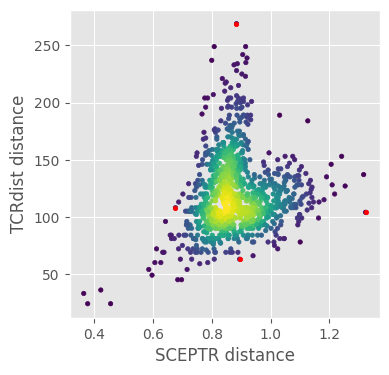

In [16]:
plt.figure(figsize=(4,4))

plt.scatter(sceptr_dists, tcrdist_dists, s=10, c=density_estimates)
plt.scatter(summaries["SCEPTR"], summaries["TCRdist"], s=10, c="r")

plt.xlabel("SCEPTR distance")
plt.ylabel("TCRdist distance")
plt.show()

# Random sample

In [17]:
tcr_sample = tanno_test.sample(5000)

sceptr_dists = sceptr_model.calc_pdist_vector(tcr_sample)
tcrdist_dists = tcrdist_model.calc_pdist_vector(tcr_sample)
tcrdist_alpha_dists = tcrdist_model_alpha.calc_pdist_vector(tcr_sample)
tcrdist_beta_dists = tcrdist_model_beta.calc_pdist_vector(tcr_sample)

In [18]:
mask = tcrdist_dists<250

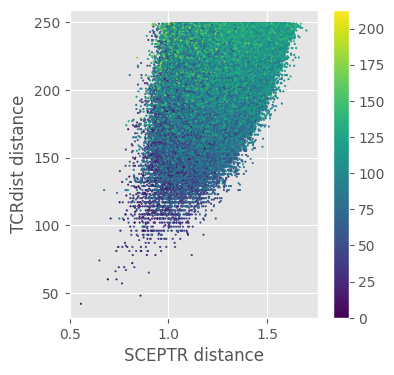

In [19]:
plt.figure(figsize=(4,4))
plt.scatter(sceptr_dists[mask], tcrdist_dists[mask], s=1, c=tcrdist_alpha_dists[mask])
plt.xlabel("SCEPTR distance")
plt.ylabel("TCRdist distance")
plt.colorbar()
plt.show()

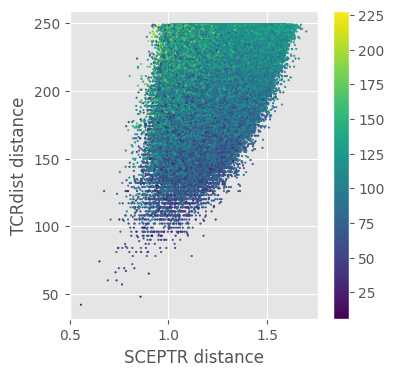

In [20]:
plt.figure(figsize=(4,4))
plt.scatter(sceptr_dists[mask], tcrdist_dists[mask], s=1, c=tcrdist_beta_dists[mask])
plt.xlabel("SCEPTR distance")
plt.ylabel("TCRdist distance")
plt.colorbar()
plt.show()

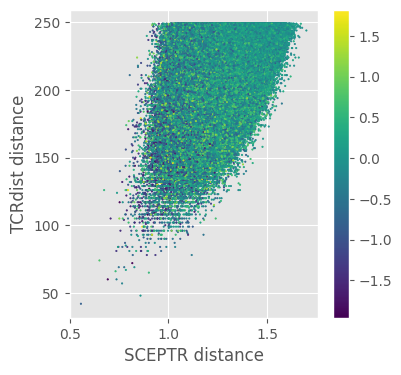

In [21]:
plt.figure(figsize=(4,4))
plt.scatter(sceptr_dists[mask], tcrdist_dists[mask], s=1,
            c=((tcrdist_alpha_dists/np.mean(tcrdist_alpha_dists)
                     -tcrdist_beta_dists/np.mean(tcrdist_beta_dists))
                  /(tcrdist_dists/np.mean(tcrdist_dists)))[mask])
plt.xlabel("SCEPTR distance")
plt.ylabel("TCRdist distance")
plt.colorbar()
plt.show()

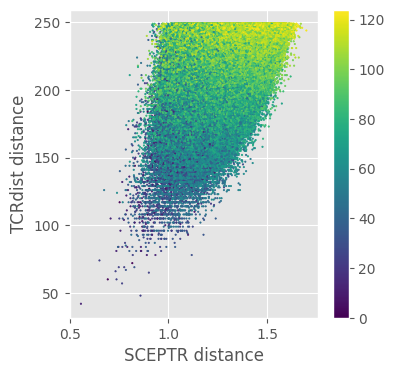

In [22]:
plt.figure(figsize=(4,4))
plt.scatter(sceptr_dists[mask], tcrdist_dists[mask],
            c=np.minimum(tcrdist_alpha_dists, tcrdist_beta_dists)[mask], s=1)
plt.xlabel("SCEPTR distance")
plt.ylabel("TCRdist distance")
plt.colorbar()
plt.show()

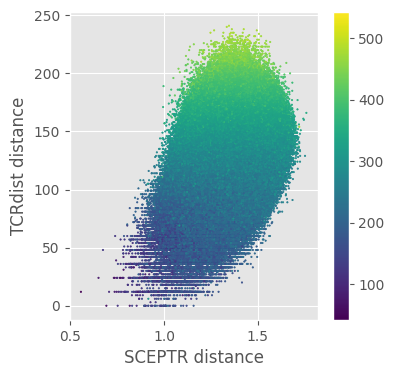

In [28]:
plt.figure(figsize=(4,4))
plt.scatter(sceptr_dists[mask], np.minimum(tcrdist_alpha_dists, tcrdist_beta_dists)[mask],
            c=tcrdist_dists[mask],
            s=1)
plt.xlabel("SCEPTR distance")
plt.ylabel("TCRdist distance")
plt.colorbar()
plt.show()

In [24]:
import scipy.stats

for tdist in [tcrdist_dists, tcrdist_alpha_dists, tcrdist_beta_dists]:
    print(scipy.stats.spearmanr(sceptr_dists, tdist))

SignificanceResult(statistic=0.3372504002445409, pvalue=0.0)
SignificanceResult(statistic=0.2055642435480251, pvalue=0.0)
SignificanceResult(statistic=0.24859530319826004, pvalue=0.0)


In [25]:
print(scipy.stats.spearmanr(sceptr_dists, np.minimum(tcrdist_alpha_dists, tcrdist_beta_dists)))
print(scipy.stats.spearmanr(sceptr_dists, scipy.stats.hmean(np.vstack([tcrdist_alpha_dists, tcrdist_beta_dists]), axis=0)))
print(scipy.stats.spearmanr(sceptr_dists, scipy.stats.gmean(np.vstack([tcrdist_alpha_dists, tcrdist_beta_dists]), axis=0)))
print(scipy.stats.spearmanr(sceptr_dists, np.maximum(tcrdist_alpha_dists, tcrdist_beta_dists)))

SignificanceResult(statistic=0.3527628154882956, pvalue=0.0)
SignificanceResult(statistic=0.3537179299503759, pvalue=0.0)
SignificanceResult(statistic=0.34769517756520896, pvalue=0.0)
SignificanceResult(statistic=0.20893139234365074, pvalue=0.0)


In [26]:
mask = sceptr_dists<2.0
alphas = [-20, -10, -1, 0, 1, 5, 10, 20]
rhos = [scipy.stats.pearsonr(sceptr_dists[mask], scipy.stats.pmean(np.vstack([tcrdist_alpha_dists[mask], tcrdist_beta_dists[mask]]),
                                                                   p=alpha, axis=0)).statistic
            for alpha in alphas]

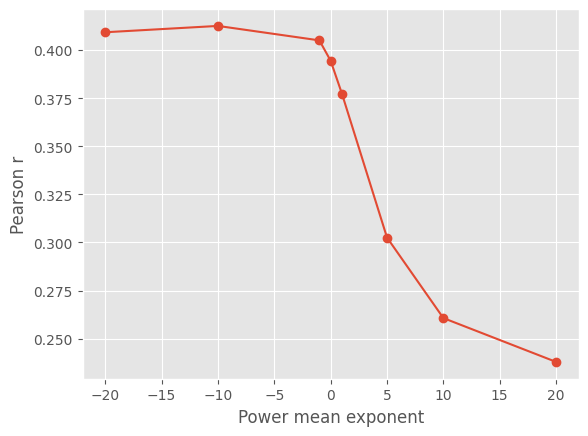

In [30]:
plt.plot(alphas, rhos, '-o')
plt.xlabel(r'Power mean exponent')
plt.ylabel('Pearson r');
plt.savefig('Chain_Averaging.png')